<a href="https://colab.research.google.com/github/prasadanvekar/elvtrdocs/blob/main/Asssignment8_Financial_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install the Yahoo finance package and pmdarima package
!pip install yfinance pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.1 MB/s eta 0:00:00


[*********************100%%**********************]  1 of 1 completed


-------Raw Data-------
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2016-01-04  25.652500  26.342501  25.500000  26.337500  23.977480  270597600
2016-01-05  26.437500  26.462500  25.602501  25.677500  23.376616  223164000
2016-01-06  25.139999  25.592501  24.967501  25.174999  22.919144  273829600
2016-01-07  24.670000  25.032499  24.107500  24.112499  21.951849  324377600
2016-01-08  24.637501  24.777500  24.190001  24.240000  22.067924  283192000
-------Engineered Data-------
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2016-01-04  25.652500  26.342501  25.500000  26.337500  23.977480  270597600   
2016-01-05  26.437500  26.462500  25.602501  25.677500  23.376616  223164000   
2016-01-06  25.139999  25.592501  24.967501  25.174999  22.919144  273829600   
2016-01-

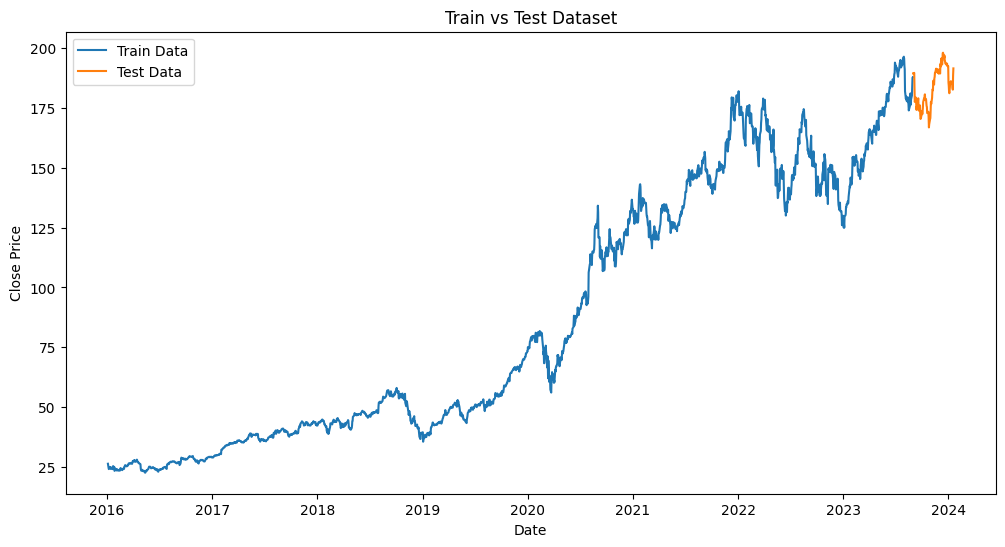

Mean Absolute Error (MAE) for linear regression: 3.07
Mean Squared Error (MSE) for linear regression: 15.14
Root Mean Squared Error (RMSE) for linear regression: 3.89


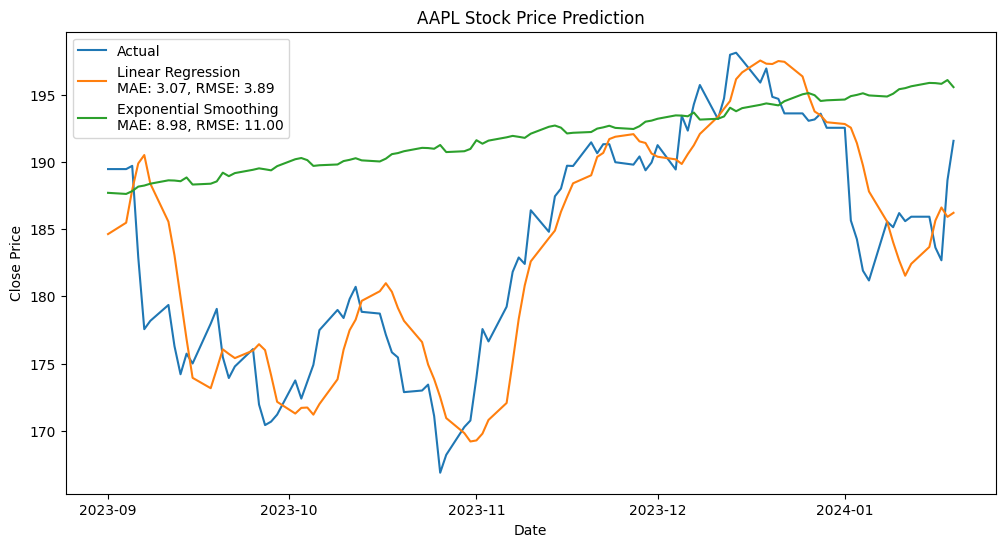

Linear Regression Metrics:
MAE: 3.07
MSE: 15.14
RMSE: 3.89

Exponential Smoothing Metrics:
MAE: 8.98
MSE: 120.92
RMSE: 11.00


In [40]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

# Data Acquisition
ticker = 'AAPL'
stock_data = yf.download('AAPL', start='2016-01-01', end='2024-01-21')
stock_data.sort_index(ascending=True, inplace=True)

# Ensure proper DatetimeIndex with frequency for time series analysis
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.asfreq('B', method='ffill')

print('-------Raw Data-------')
print(stock_data.head())

# Calculate rolling averages
stock_data['7_day_avg'] = stock_data['Close'].rolling(window=7, min_periods=1).mean()
stock_data['30_day_avg'] = stock_data['Close'].rolling(window=10, min_periods=1).mean()

print('-------Engineered Data-------')
print(stock_data.head())
print(stock_data.describe())

# Feature engineering
stock_data['7_day_shifted'] = stock_data['7_day_avg'].shift(1)
stock_data['30_day_shifted'] = stock_data['30_day_avg'].shift(1)

# Split the data into training and test sets
split_date = pd.to_datetime('2023-09-01')
train = stock_data.loc[stock_data.index < split_date]
test = stock_data.loc[stock_data.index >= split_date]

# Prepare the training and test data for Linear Regression
X_train = train[['7_day_shifted','30_day_shifted']].dropna()

print(X_train.shape)

y_train = train['Close'][1:].values

print(y_train.shape)

X_test = test[['7_day_shifted','30_day_shifted']].dropna()
y_test = test['Close']

print(X_test.shape)
print(y_test.shape)

# Visualization of Train and Test Datasets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Train Data')
plt.plot(test.index, test['Close'], label='Test Data')
plt.title('Train vs Test Dataset')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Fit a linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict the trend for the test set
reg_predictions = model_lr.predict(X_test)

# Exponential Smoothing model

window_size = 30
exp_model = ExponentialSmoothing(train['Close'], trend='add', seasonal='add', seasonal_periods=window_size)
exp_fit = exp_model.fit()
exp_predictions = exp_fit.forecast(len(test))

# Evaluation metrics
reg_mae = mean_absolute_error(y_test, reg_predictions)
reg_mse = mean_squared_error(y_test, reg_predictions)
reg_rmse = np.sqrt(reg_mse)

exp_mae = mean_absolute_error(y_test, exp_predictions)
exp_mse = mean_squared_error(y_test, exp_predictions)
exp_rmse = np.sqrt(exp_mse)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, reg_predictions, label=f'Linear Regression\nMAE: {reg_mae:.2f}, RMSE: {reg_rmse:.2f}')
plt.plot(test.index, exp_predictions, label=f'Exponential Smoothing\nMAE: {exp_mae:.2f}, RMSE: {exp_rmse:.2f}')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Commentary
print(f'Linear Regression Metrics:\nMAE: {reg_mae:.2f}\nMSE: {reg_mse:.2f}\nRMSE: {reg_rmse:.2f}')
print(f'\nExponential Smoothing Metrics:\nMAE: {exp_mae:.2f}\nMSE: {exp_mse:.2f}\nRMSE: {exp_rmse:.2f}')



